<a href="https://colab.research.google.com/github/Roseliano/-biblioteca-pandas/blob/main/Notebook_data_wrangling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Setup**

In [20]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px

from sklearn import datasets
from sklearn.preprocessing import scale, minmax_scale, power_transform

from IPython.core.display import HTML
from ipywidgets import interact, widgets

In [21]:
sns.set_theme(
    context='talk',
    style='ticks',
    font_scale=.8,
    rc={
        'figure.figsize': (12,8)
    }
)

In [22]:
#função pra deixar as tabelas na mesma linha (lado a lado)
def display_side_by_side(dataframes:list,titles:list):
    html_str=''
    for df,title in zip(dataframes, titles):
        html_str+=f'<span>{title}:</span>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+="&nbsp"*10
    display(HTML(html_str))

# **Estruturação dos dados**

## Merge/Concat/Join

Frequentemente precisamos juntar bases diferentes em um só, para tanto para facilitar análise exploratória quanto para preparar o dataset para modelagem.

As funções `merge`, `concat` e `join` do Pandas nos ajudam nesta parte de estruturação dos dados, e há um tutorial excelente do próprio Pandas [neste link](https://pandas.pydata.org/docs/user_guide/merging.html#merge-join-concatenate-and-compare).

### Merge

Este método do pandas é o mais similar aos JOINs do SQL.  
Tabela de exemplo comparativo:


| Merge method   | SQL Join Name    | Description                                         |
|:---------------|:-----------------|:----------------------------------------------------|
| left           | LEFT OUTER JOIN  | Use keys from left frame only                       |
| right          | RIGHT OUTER JOIN | Use keys from right frame only                      |
| outer          | FULL OUTER JOIN  | Use union of keys from both frames                  |
| inner          | INNER JOIN       | Use intersection of keys from both frames           |
| cross          | CROSS JOIN       | Create the cartesian product of rows of both frames |

In [23]:
df1 = pd.DataFrame(
    {
        "key": ["K0", "K1", "K2", "K3"],
        "A": ["A0", "A1", "A2", "A3"],
        "B": ["B0", "B1", "B2", "B3"],
    }, index=range(4)
)

df2 = pd.DataFrame(
    {
        "key": ["K1", "K2", "K3", "K4"],
        "C": ["C1", "C2", "C3", "C4"],
        "D": ["D1", "D2", "D3", "D4"],
    }, index=range(1,5)
)

df3 = pd.DataFrame(
    {
        "key": ["K1", "K2", "K3", "K4"],
        "E": ["E1", "E2", "E3", "E4"],
        "F": ["F1", "F2", "F3", "F4"],
    }, index=range(1,5)
)

In [24]:
display_side_by_side([df1,df2, df3], ['df1','df2', 'df3'])

,key,A,B
0,K0,A0,B0
1,K1,A1,B1
2,K2,A2,B2
3,K3,A3,B3
,key,C,D
1,K1,C1,D1
2,K2,C2,D2
3,K3,C3,D3
4,K4,C4,D4
,key,E,F


In [25]:
# Mostrar merge dos dois jeitos esse exemplo assim:
#exemplo 1:
df1.merge(df2)

# Por padrão, ele traz um inner join das tabelas, trazendo somente os resultados que convergem


,key,A,B,C,D
0,K1,A1,B1,C1,D1
1,K2,A2,B2,C2,D2
2,K3,A3,B3,C3,D3


In [26]:
# Exemplo 2:
df1.merge(df3, on='key', how='inner')

# Também é possível setar como queremos a convergencia

,key,A,B,E,F
0,K1,A1,B1,E1,F1
1,K2,A2,B2,E2,F2
2,K3,A3,B3,E3,F3


In [27]:
# Mostrar todos
df_inner = df1.merge(df2, on='key', how='inner') #mantém todas as categorias em comum nos dois df
df_left = df1.merge(df2, on='key', how='left') #mantém todas as categorias existentes na coluna da esquerda
df_right = df1.merge(df2, on='key', how='right') #mantém todas as categorias existentes na coluna da direita


#Função de mostrar tabela -> display_side_by_side([lista = formato string])

display_side_by_side(
    dataframes=[df1, df2, df_inner, df_left, df_right],
    titles=['df1', 'df2', 'inner_merge', 'left_merge', 'right_merge']
)

In [28]:
#função merge da aula
@interact(method=['inner','left', 'right','outer'])
def merge(method):
  df_merge=df1.merge(df2, how=method)
  display_side_by_side(
      [df1,df2,df_merge],
      ['df1','df2',f'{method}_join']
  )

interactive(children=(Dropdown(description='method', options=('inner', 'left', 'right', 'outer'), value='inner…

In [29]:
def merge(merge_method):
  display_side_by_side([df1, df2, df1.merge(df2, how=merge_method)], ['df1','df2', f'{merge_method} merge'])

interact(merge, df1=df1, df2=df2, merge_method=widgets.Dropdown(options=['inner','left','right','outer'], style={'description_width': 'initial'}));

interactive(children=(Dropdown(description='merge_method', options=('inner', 'left', 'right', 'outer'), style=…

### Concat

A concatenação acontece quando temos que juntar as tabelas uma abaixo da outra (equivalente ao `UNION` do  SQL), ou uma ao lado da outra.

Por exemplo de concatenação vertical (default) `pd.concat([df1,df2,df3])`:  
![](https://pandas.pydata.org/docs/_images/merging_concat_basic.png)  
<caption><b>Fonte:</b> <a href="https://pandas.pydata.org/docs/user_guide/merging.html">https://pandas.pydata.org/docs/user_guide/merging.html</a></caption>

Exemplo de concatenação horizontal (`pd.concat([df1,df4], axis=1)`):
![](https://pandas.pydata.org/docs/_images/merging_concat_axis1.png)  
<caption><b>Fonte:</b> <a href="https://pandas.pydata.org/docs/user_guide/merging.html">https://pandas.pydata.org/docs/user_guide/merging.html</a></caption>





In [30]:
#@title
%%html
<style>
div.warn {
    color: #9E8C50;
    background-color: #F8F4C3;
    border-left: 5px solid #9E8C50;
    padding: 0.5em;
    }
 </style>
<div class=warn>
<b>Nota: </b> Observe que, por padrão, Pandas considera os nomes das colunas e índeces ao unir as tabelas.
</div>

In [31]:
# Separando exemplo de data_frame
df_A = df1.iloc[:2]
df_B = df1.iloc[2:]
display_side_by_side([df_A,df_B], ['df_A','df_B'])

,key,A,B
0,K0,A0,B0
1,K1,A1,B1
,key,A,B
2,K2,A2,B2
3,K3,A3,B3


In [32]:
# Concatenando verticalmente
pd.concat([df_A,df_B])

,key,A,B
0,K0,A0,B0
1,K1,A1,B1
2,K2,A2,B2
3,K3,A3,B3


In [33]:
# Concatenando horizontalmente
pd.concat([df_A,df_B], axis=1)

,key,A,B,key,A,B
0,K0,A0,B0,NaN,NaN,NaN
1,K1,A1,B1,NaN,NaN,NaN
2,NaN,NaN,NaN,K2,A2,B2
3,NaN,NaN,NaN,K3,A3,B3


In [34]:
# Concatenando horizontalmente, forçando mesmo index
pd.concat([df_A,df_B.reset_index()], axis=1)

,key,A,B,index,key,A,B
0,K0,A0,B0,2,K2,A2,B2
1,K1,A1,B1,3,K3,A3,B3


### Join

A função join do Pandas considere como chave o index:

![](https://pandas.pydata.org/docs/_images/merging_join.png)

In [35]:
df_left = pd.DataFrame({
    'A':['A0', 'A1', 'A2'],
    'B':['B0','B1','B2']
}, index=['K0','K1','K2'])

df_right = pd.DataFrame({
    'C':['C0','C1', 'C2'],
    'D':['D0','D1','D2']
}, index=['K0','K2','K3'])

df_join = df_left.join(df_right, how='inner')

display_side_by_side([df_left, df_right, df_join],['df_left', 'df_right', 'df_join'] )

## Group by

Um dos métodos mais utilizados do Pandas (e em outras linguagens) é o `groupby`.

A lógica do `groupby` é bem simples e conhecida como **split-apply-combine:**

1. A primeira etapa é separar a tabela (split) em tabelas menores, cada uma com categorias únicas (representando um grupo) da(s) coluna(s) que desejamos agrupar.
2. Aplicar uma função separadamente em cada uma destas tabelas. Pode ser uma função de **agregação** gerando uma métrica de resumo, uma função de **transformação**, modificando os valores, ou uma função de **filtro**, onde filtraremos grupos que se encaixam dentro de uma regra.
3. Por fim, combina-se novamente estas tabelas para formar uma única tabela de saída.

Segue um esquema de exemplo com um função de agregação (soma):

![](https://miro.medium.com/max/2400/1*w2oGdXv5btEMxAkAsz8fbg.png)  
Fonte: [https://medium.com/analytics-vidhya/split-apply-combine-strategy-for-data-mining-4fd6e2a0cc99](https://medium.com/analytics-vidhya/split-apply-combine-strategy-for-data-mining-4fd6e2a0cc99)

Maiores detalhes no [guia de uso da documentação](https://pandas.pydata.org/docs/user_guide/groupby.html#group-by-split-apply-combine).

In [36]:
# Vamos utilizar como exemplo o dataset de gorjetas em um restaurante
df = sns.load_dataset('tips')
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


###Agregações


In [37]:
# Podemos agrupar por uma coluna e aplicar uma função em todas colunas (passíveis de aplicação da função)
df.groupby(['sex']).mean()

TypeError: 'Categorical' with dtype category does not support reduction 'mean'

In [ ]:
# Podemos agrupar por uma coluna e aplicar uma função em uma coluna-alvo retornando um pandas.Series
df.groupby('sex')['total_bill'].mean()

In [ ]:
# Podemos agrupar por uma coluna e aplicar uma função em um coluna-alvo retornando um pandas.DataFrame (duplo "[[")
df.groupby(['smoker'])[['total_bill']].sum()

In [ ]:
# Podemos agrupar por múltiplas colunas
df.groupby(['time','day'])[['total_bill', 'tip']].agg(['mean', 'max','min', 'sum', 'count'])

In [ ]:
# Podemos aplicar múltiplas funções de agregação suportadas pelo pandas
df.groupby(['time'])[['total_bill']].agg(['min','median','max'])

In [ ]:
# Podemos aplicar funções customizadas simples
df.groupby(['time'])[['total_bill']].apply(lambda x: np.sum(x)+1)

In [ ]:
## Mais exemplos

# Podemos agrupar por uma coluna e aplicar uma função em todas colunas (passíveis de aplicação da função)
df.groupby(['sex']).sum()

# Podemos agrupar por uma coluna e aplicar uma função em um coluna-alvo retornando um pandas.Series
df.groupby(['sex'])['total_bill'].sum()

# Podemos agrupar por uma coluna e aplicar uma função em um coluna-alvo retornando um pandas.DataFrame (duplo "[[")
df.groupby(['smoker'])[['total_bill']].sum()

# Podemos agrupar por múltiplas colunas
df.groupby(['sex','smoker'])[['total_bill']].mean()

# Podemos aplicar múltiplas funções de agregação suportadas pelo pandas
df.groupby(['time'])[['total_bill']].agg(['min','median','max'])

# Podemos aplicar funções customizadas simples
df.groupby(['time'])[['total_bill']].apply(lambda x: np.sum(x)+1)

# Podemos aplicar funções customizadas mais complexas
def mean_diff(subdf):
  """Calcula a média do quanto cada gorjeta representou da conta total"""
  return np.mean( subdf['tip'] / subdf['total_bill'] )

df.groupby('sex').apply(lambda x: str(round(mean_diff(x)*100, 2))+'%')



In [ ]:
## -- Transformação -- ##

# Padronização por grupo
df.groupby('sex')[['total_bill','tip']].transform(scale)

# Rolling mean
df.groupby('sex')[['total_bill','tip']].rolling(3).mean()

In [ ]:
groups = df.groupby(['sex','smoker'])

In [ ]:
groups.get_group(('Female','Yes'))

###Demonstração Gráfica

In [ ]:
# Exemplo das mesmas informações com groupby e plot

# Groupby
print(df.groupby(['sex','smoker']).tip.sum(), '\n')

# Seaborn barplot
sns.barplot(data=df, x='sex', y='tip', hue='smoker', order=['Female','Male'], hue_order=['No','Yes'], estimator=np.sum, ci=False)
plt.grid(axis='y', alpha=.2)
plt.show()

# Plotly barplot
px.bar(data_frame=df, x='sex', y='tip', color='smoker', barmode="group")

## Pivot table

In [ ]:
# primeiras linhas
df.head()

In [ ]:
# exemplo de pivot: sex - time - tip
df.pivot_table(index='sex', columns='day', values='tip')

# Padrão dos valores é a média

In [ ]:
# exemplo de pivot: sex - time - total_bill/tip
df.pivot_table(index='sex', columns='time', values=['total_bill','tip'], aggfunc=['sum', 'mean'])

In [ ]:
# exemplo de pivot: sex - time/day - total_bill/tip
df.pivot_table(index='sex', columns=['time','day'], values=['total_bill','tip'], aggfunc=np.median)

In [ ]:
# Exemplo com groupby para comparação
df.groupby(['sex','time','day'])[['total_bill','tip']].median()

In [ ]:
# Exemplo de pivot com múltiplas funções de agregação
df.pivot_table(index='sex', columns='time', values='tip', aggfunc=['mean', np.median, np.std, lambda x: x.sum()])

In [ ]:
# Exemplo de pivot especificando funções em dicionário

agg_dict = {'tip': 'mean', 'total_bill':[np.median, 'min']}

df.pivot_table(index='sex', columns='time', aggfunc=agg_dict)

Tabelas no formato long e wide:

In [ ]:
df.groupby(['day','time'])['tip'].mean()

In [ ]:
df.pivot_table(index='time', columns='day', values='tip')

In [ ]:
# Selecionando as colunas day,time e tip, a tabela pode ser considerada long, pois elementos se repetem:
df_pivot = df.pivot_table(index='day', columns='time', values='tip').reset_index()
df_pivot

In [ ]:
# Usando pivot_table, a tabela ficaria no formato wide, pois os elementos não se repetem
df_pivot.melt(id_vars='day')\


In [ ]:
# Para transformar em long novamente, utilizamos a função `melt` e podemos plotar utilizando seaborn/plotly
df_pivot.melt(id_vars='day')\
.plot.bar(backend='plotly', x='day', y='value', color='time', barmode='group')

# Categorical encoding

**Disclaimer sobre variáveis numéricas:**

Para as variáveis numéricas, alguns algoritmos requerem que os dados estejam **padronizados**. Vimos em data cleaning, ao lidar com outliers, a função `scale` do `sklearn` que padroniza por Z-score. Vale olhar também o `minmax_scale`, outro metódo de pradonização comum que transforma os dados em valores de 0 a 1 (zero sendo o valor mínimo e 1 o máximo).

Também vimos as funções de **transformação** como Box-Cox, que aproxima a distribuição dos dados à uma distribuição normal.

Todos estes métodos já foram abordados e podem ser utilizados para tratar variáveis numéricas para modelos que necessitem deste tratamento.

&nbsp;

---

&nbsp;

**Encoding de variáveis categóricas**

As variáveis categóricas precisam, necessariamente, ser tratadas para que sejam representadas por números, uma vez que os modelos não compreendem texto.

Obs: Alguns modelos podem até permitir input de texto, mas dentro deles eles mesmos fazem essa tratativa de encoding.

Existem duas abordagens principais para encoding de variáveis categóricas:
1. OneHotEncoding: criação de novas colunas para cada categoria informando se esta categoria está ou não presente nas respectivas observações
2. LabelEncoder/OrdinalEncoder: substitui o texto das categorias por números, matendo um "dicionário" para saber ter o mapeamento do que cada número representa.

## OneHotEncoder

Uma opção seria utilizar diretamente o pandas para este propósito:

In [ ]:
df.head()

In [ ]:
pd.get_dummies(df)

Ou também podemos utilizar

In [ ]:
from sklearn.preprocessing import OneHotEncoder

In [ ]:
encoder = OneHotEncoder(drop='if_binary')
encoder

In [ ]:
df.select_dtypes(exclude='category')

In [ ]:
categorical_columns = df.select_dtypes(exclude='number').columns

In [ ]:
encoder.fit(df[categorical_columns])

In [ ]:
encoder.categories_
encoder.drop_idx_
encoder.feature_names_in_
encoder.get_feature_names_out()

In [ ]:
encoder.categories_

In [ ]:
encoder.drop_idx_

In [ ]:
encoder.feature_names_in_

In [ ]:
encoder.get_feature_names_out()

In [ ]:
pd.DataFrame(
    data=encoder.transform(df[categorical_columns]).toarray(),
    columns=encoder.get_feature_names_out()
)

In [ ]:
encoder.transform(df[categorical_columns].replace({'Male':'male'}))

## LabelEncoder / OrdinalEncoder

Usando pandas

In [ ]:
# Convertendo para categoria
df_cat = df.copy()

df_cat[categorical_columns] = df_cat[categorical_columns].astype('category')
df_cat.info()

In [ ]:
{col: dict( enumerate(df_cat[col].cat.categories) ) for col in categorical_columns}

In [ ]:
# Pegando das categorias

In [ ]:
# Modificando colunas
df_cat[categorical_columns] = df_cat[categorical_columns].apply(lambda x: x.cat.codes)

In [ ]:
df_cat.head()

In [ ]:
# Usando factorize
df['sex'].factorize()

Usando sklearn

In [ ]:
from sklearn.preprocessing import OrdinalEncoder

In [ ]:
OrdinalEncoder?

In [ ]:
# Instanciando OrginalEncoder
encoder = OrdinalEncoder().fit(df[categorical_columns])

In [ ]:
# Mostrando atributos
encoder.categories_

In [ ]:
# Transformando dados esperados
df_cat[categorical_columns] = encoder.transform(df[categorical_columns])

In [ ]:
df_cat.head()

# Filtros

# New Section

In [ ]:
# Filtro convencional
df.head()

df[df.tip > 4].head()

In [ ]:
# Filtro com query

df.query('tip > 4').head()

In [ ]:
# Filtro com query e variável
minimo_aceitavel = 3
df.query('tip>@minimo_aceitavel')

In [ ]:
# Múltiplos filtros convencionais
df[ (df.tip>2) & (df.total_bill<20)].head()

In [ ]:
df.day.unique()

In [ ]:
df[df.day.isin(['Sat','Sun'])].day.unique()

In [ ]:
# Múltiplos filtros com query
df.query('tip>2 & total_bill<20').head()

In [ ]:
# Filtro com index
df_index = df.set_index('sex')
df_index

In [ ]:
df_index.loc['Female', ['total_bill','tip']]

Filtrando data

In [ ]:
# Loading aircrash dataset
fatalities_dataset_path = 'https://query.data.world/s/2gfb7bmzhna6kcbpc7admwa6cexprz'
df_datetime = pd.read_csv(fatalities_dataset_path, usecols=['Date','Fatalities'], parse_dates=['Date'], index_col='Date').sort_index()
df_datetime.head()

In [39]:
# Filtrando com .loc
df_datetime.loc['2000-05-10':'2010-05-10']

NameError: name 'df_datetime' is not defined

In [ ]:
# Resetando index
df = df_datetime.reset_index()
df.head()

In [ ]:
# Filtrando com filtro convencional de coluna - between
df[df.Date.between('2000-05-10', '2010-05-10')]

In [ ]:
# Filtrando com filtro convencional de coluna - gt/lt
df[(df.Date>='2000-05-10') & (df.Date.le('2010-05-10'))]

# Enriquecimento (Feature Engineering)

Feature engineering, ou enriquecimento, consiste em uma das etapas mais importantes para construir bons modelos de machine learning.

O objetivo da feature engineering é tornar os dados melhor aproveitáveis para resolver o problema proposto. Através da feature engineering, podemos:

- Melhor a performance preditiva do modelo
- Reduzir custos computacionais ou necessidades de dados
- Aumentar a interpretabilidade dos resultados

Novas features podem ser geradas a partir das próprias features do datataset através de operações aritméticas simples. Conside por exemplo o dataset de gorjetas previamente estudado:

In [40]:
df = sns.load_dataset('tips')
df.head()

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4


Neste caso, poderíamos adicionar uma coluna que representa o quanto a gorjeta representa da conta total, ou o valor da conta divido pelo tamanho da mesa (size):

In [41]:
df['tip_normalized'] = df['tip'] / df['total_bill']
df.head()

,total_bill,tip,sex,smoker,day,time,size,tip_normalized
0,16.99,1.01,Female,No,Sun,Dinner,2,0.059447
1,10.34,1.66,Male,No,Sun,Dinner,3,0.160542
2,21.01,3.50,Male,No,Sun,Dinner,3,0.166587
3,23.68,3.31,Male,No,Sun,Dinner,2,0.139780
4,24.59,3.61,Female,No,Sun,Dinner,4,0.146808


Lembre-se, contudo, que para um modelo supervisionado de machine learning, todas as features trabalhadas no treino devem ser possíveis de serem utilizada em novos dados que virão também, como input do modelo.

Outra maneira de adicionar colunas consiste em capturar categorias mais específicas em uma variável categórica com texto.

Por exemplo, considere a base de dados do Titanic:

In [42]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv', index_col='PassengerId')
df.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Nesta base, o nome do completo do passageiro não seria útil, visto que são nomes únicos. Contudo, há um tratamento pessoal em cada nome (como Mr., Mrs.) e isso poderia contribuir para melhor performance do modelo.

In [43]:
df.Name.str.extract('.+?, (.+?)\.', expand=False)

PassengerId
1        Mr
2       Mrs
3      Miss
4       Mrs
5        Mr
       ... 
887     Rev
888    Miss
889    Miss
890      Mr
891      Mr
Name: Name, Length: 891, dtype: object

In [44]:
df['personal_title'] = df.Name.str.extract('.+?, (.+?)\.', expand=False)
df.head()

# '.+?, (.+?)\. > padrão no texto, depois da virgula e antes do ponto

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,personal_title
PassengerId,,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


## Selecionando features

A parte de seleção de features também é muito importante e o domínio de negócio/área conta muito aqui.

### Análise gráfica

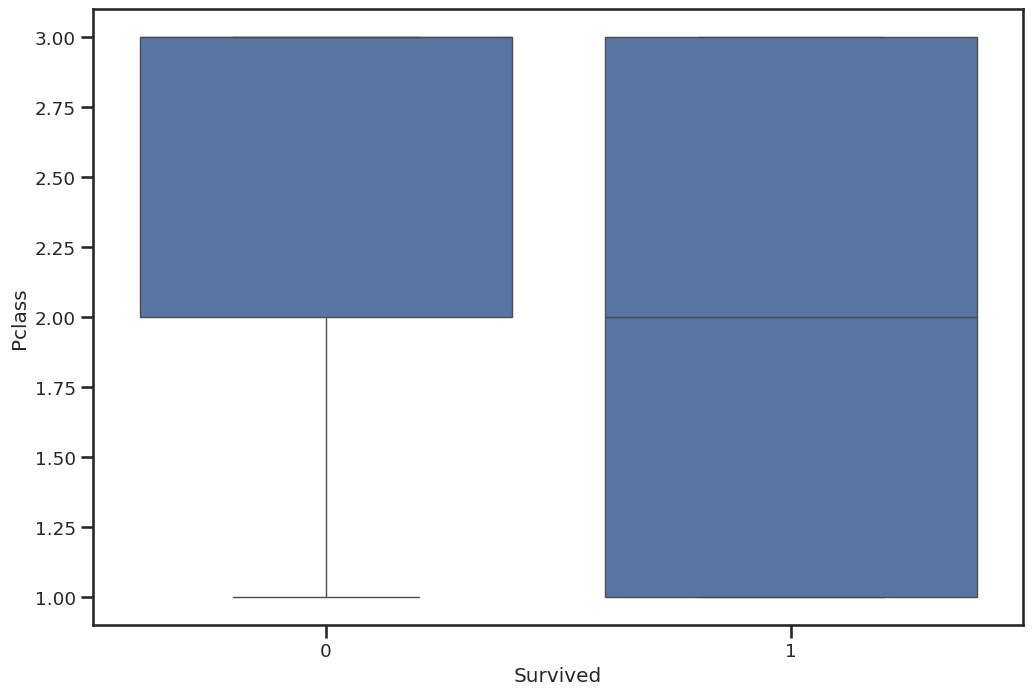

In [45]:
# Observando diferenças nas distribuições
sns.boxplot(data=df, x='Survived', y='Pclass');

In [46]:
# Observando correlação (linear)
sns.heatmap(df.corr(), cmap='RdBu_r', center=0, annot=True);

ValueError: could not convert string to float: 'Braund, Mr. Owen Harris'

### Mutual information

In [ ]:
from sklearn.feature_selection import mutual_info_classif, mutual_info_regression

In [ ]:
# Drop columns and NAs
df_model = df.drop(columns=['Name','Ticket','Cabin']).dropna()
df_model.head()

In [ ]:
target = df_model['Survived']
df_features = df_model.drop(columns='Survived')

In [ ]:
cat_features = df_features.select_dtypes(exclude='number').columns

encoder = OrdinalEncoder()
df_features[cat_features] = encoder.fit_transform(df_features[cat_features]).astype(int)

df_features.head()

In [ ]:
discrete_features = df_features.dtypes==int
discrete_features

In [ ]:
scores = mutual_info_classif(X=df_features, y=target, discrete_features=discrete_features)
scores

In [ ]:
pd.Series(data=scores, index=df_features.columns).sort_values().plot.barh()

**Observação:** MI, assim como correlação, é uma métrica **univariada**, portanto, não necessariamente uma variável com baixo score de MI vai ter pouca importância para o modelo, pois pode ser que, quando associada à outra variável, ambas variáveis contribuam para o modelo.

# Pipelines

In [ ]:
from sklearn import set_config
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder

set_config(display="diagram")

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv', index_col='PassengerId')
df['personal_titles'] = df.Name.str.extract('.*, (.+?)\.', expand=False)
df = df.drop(columns=['Name','Ticket','Cabin']).dropna()

df_features = df.drop(columns='Survived')
target = df['Survived']

df_features.head()

In [ ]:
# Selecionando features numéricas e categóricas
numerical_features = df_features.select_dtypes('number').columns
categorical_features = df_features.select_dtypes(exclude='number').columns

print(numerical_features)
print(categorical_features)

In [ ]:
# Aplicando column transformer
preprocessing_pipeline = make_column_transformer(
    [StandardScaler(), numerical_features],
    [OneHotEncoder(), categorical_features]
)

preprocessing_pipeline

In [ ]:
preprocessing_pipeline.fit(df_features)

In [ ]:
pd.DataFrame(
  data=preprocessing_pipeline.transform(df_features).toarray(),
  columns=preprocessing_pipeline.get_feature_names_out()
)

In [ ]:
# Múltiplos processamentos no column transformer
# Aplicando column transformer
preprocessing_pipeline = make_column_transformer(
    [make_pipeline(PowerTransformer(), StandardScaler()), numerical_features],
    [OneHotEncoder(), categorical_features]
)

preprocessing_pipeline.fit(df_features)

In [ ]:
# Colocando resultado em dataframe
pd.DataFrame(
  data=preprocessing_pipeline.transform(df_features).toarray(),
  columns=preprocessing_pipeline.get_feature_names_out()
)

# Conclusão do módulo

Neste módulo, vocês aprenderam:

- Como identificar e lidar com valores duplicados
- Como identificar e lidar com valores faltantes
- Como identificar e lidar com outliers
- Como identificar e lidar com dados inconsistentes através de análise univariada
- Como identificar variáveis potencialmente importantes para o modelo através da análise multivariada
- Como transformar seus dados numéricos e categóricos para aplicação do modelo
- Como estruturar os seus dados
- Como criar novas variáveis para o modelo
- Como estruturar um pipeline de pré-tratamento dos dados

In [ ]:
import seaborn as sns
df = sns.load_dataset('tips')
df